This notebook is for computing the trigger efficiency for data

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/control_data2018.json'))
datasets = dict(
    A={'files': datasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'} ,
    B={'files': datasets_['B'], 'treename': 'ffNtuples/ffNtuple'} ,
    C={'files': datasets_['C'], 'treename': 'ffNtuples/ffNtuple'} , 
    D={'files': datasets_['D'], 'treename': 'ffNtuples/ffNtuple'} ,
)

In [5]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        
        dataset_axis = hist.Cat('dataset', '')
        multiplicity_axis = hist.Bin("multiplicity", "#muons/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "jet pt [GeV]", 20, 0 , 300)
        deltaR_axis = hist.Bin("deltaR", "delta_R", 30, 0 , 5)
        
        self._accumulator = processor.dict_accumulator({

            'deltaR1': hist.Hist("Counts", dataset_axis, deltaR_axis),
            'deltaR2': hist.Hist("Counts", dataset_axis, deltaR_axis),
           
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
   

        muons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],
         
        )

        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
         
        )
        
        triggerObjs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_DoubleL2Mu23NoVtx_2Cha'],
            px=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fX'],
            py=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fY'],
            pz=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fZ'],
            energy=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fT'],
        )
 
        
        # with muons
        Tobj_Mu_pairs = muons['p4'].cross(triggerObjs['p4'], nested=True)
        dr1 = Tobj_Mu_pairs.i0.delta_r(Tobj_Mu_pairs.i1)
        dr1 = dr1.min()
        
        output['deltaR1'].fill(dataset=dataset, deltaR=dr1.flatten().flatten())  
        
        
        # with leptonjets
        Tobj_Lj_pairs = leptonjets['p4'].cross(triggerObjs['p4'], nested=True)
        dr2 = Tobj_Lj_pairs.i0.delta_r(Tobj_Lj_pairs.i1)
        dr2 = dr2.min()
        
        output['deltaR2'].fill(dataset=dataset, deltaR=dr2.flatten().flatten())  
        

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [7]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=MyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=5000000,
                                  #maxchunks=0
                                 )

Processing: 100%|██████████| 2545/2545 [01:23<00:00, 28.20items/s]


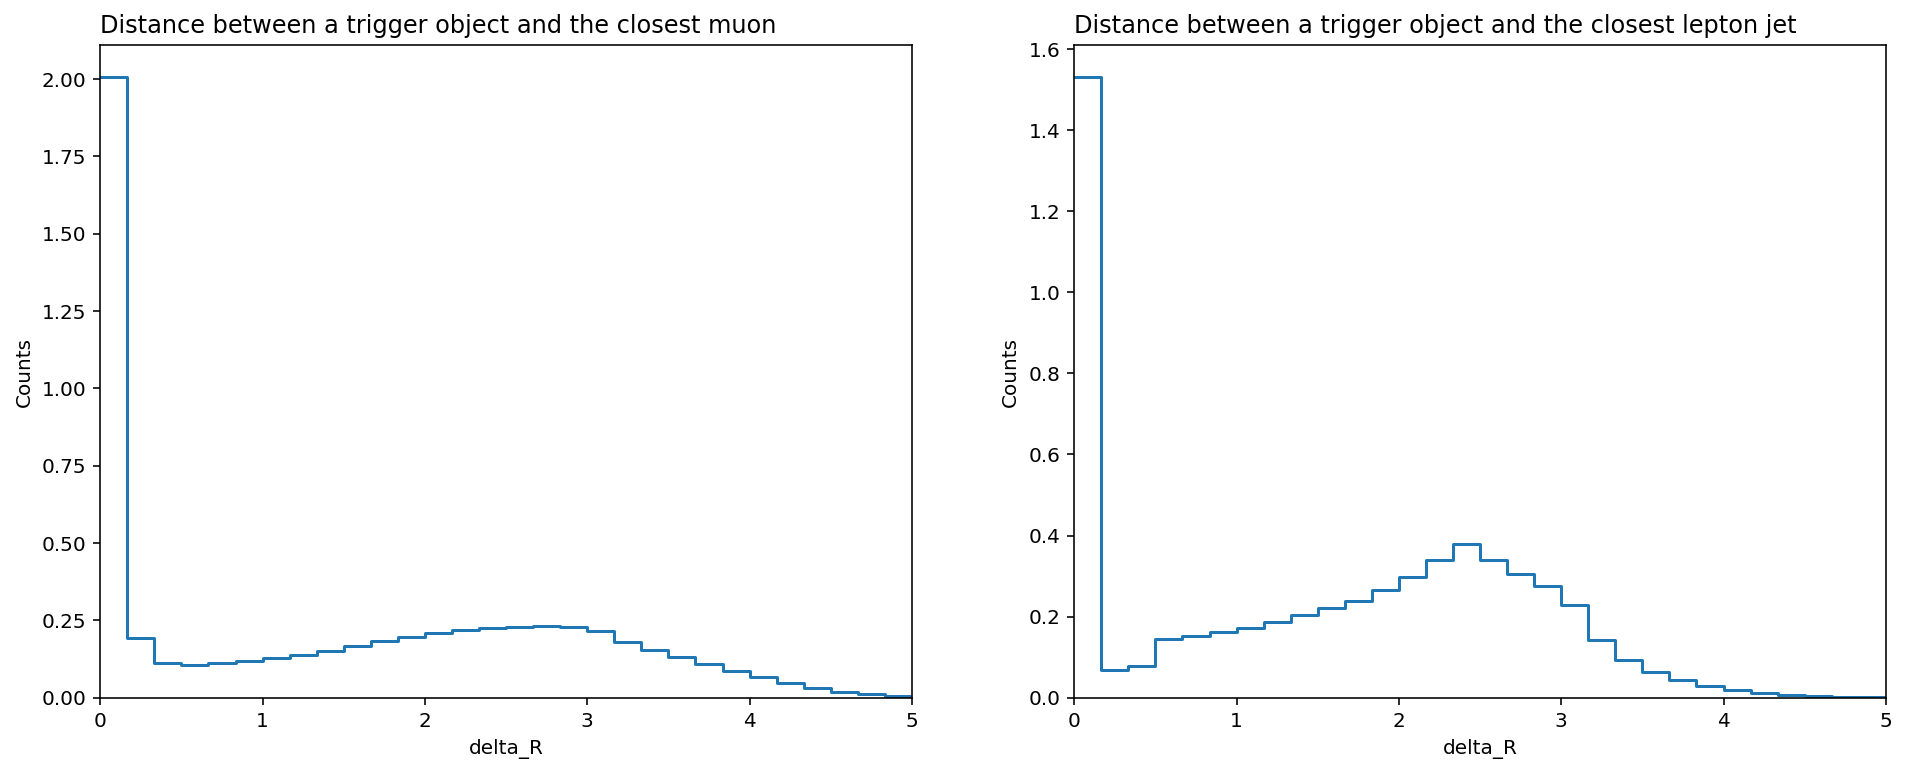

In [12]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

hist.plot1d(output['deltaR1'].sum('dataset'), ax=ax[0], density=True)
hist.plot1d(output['deltaR2'].sum('dataset'), ax=ax[1], density=True)

ax[0].set_title('Distance between a trigger object and the closest muon', x=0.0, ha="left")
ax[1].set_title('Distance between a trigger object and the closest lepton jet', x=0.0, ha="left");

#ax.set_ylim([1e-4, 1])
#ax.set_yscale('log')


